In [2]:
from itertools import cycle

import numpy as np
#from sklearn.datasets import fetch_mldata
#from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d, convolve
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import MNIST
# from torchvision import transforms
from IPython.display import clear_output
from typing import Tuple, List
from tqdm import *
%matplotlib inline

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import note_seq
import bokeh
import librosa.display

from src.features.build_features import detokenize
from src.entities.audio_params import AudioParams
from src.entities.dataset_params import DatasetParams
from src.data.make_dataset import WavMidiDataset, AudioDataset


SAMPLE_RATE = 44100
FRAME_LENGTH = 8192
OVERLAPPING = 16


audio_params = AudioParams(
    sample_rate=SAMPLE_RATE,
    frame_length=FRAME_LENGTH,
    n_mels=512,
    fmin=8,
    fmax=12500,
    window="taylor"
)
train_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="train",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)
test_params = DatasetParams(
    root_path="/mnt/d/Datasets/maestro-v3.0.0/",
    metadata="maestro-v3.0.0.csv",
    years_list=[2017],
    split="test",
    audio_params=audio_params,
    feature_size=3,
    overlapping=OVERLAPPING,
)

gpu = True

device = torch.device("cuda" if torch.cuda.is_available() and gpu else "cpu")
device

/home/ilya20/docomets/MusicTranscription/.venv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


device(type='cuda')

In [4]:
train_ds = WavMidiDataset(train_params)
test_ds = WavMidiDataset(test_params)

In [5]:
len(train_ds), len(test_ds)

(106, 18)

In [6]:
# frames, notes, times = train_ds[37]
# train_audio_ds = AudioDataset(frames, notes)
# train_loader = DataLoader(train_audio_ds, 1000)

# frames, notes, times = test_ds[7]
# test_audio_ds = AudioDataset(frames, notes)
# test_loader = DataLoader(test_audio_ds, 1000)

# train_loader = DataLoader(train_ds, 1)
# test_loader = DataLoader(test_ds, 1)

In [7]:
# loss = nn.MultiLabelMarginLoss()
# x = torch.FloatTensor([[0.1, 0.9, 0.1, 1]])
# # for target y, only consider labels 3 and 0, not after label -1
# y = torch.LongTensor([[1, 3, -1, -1]])
# # 0.25 * ((1-(0.1-0.2)) + (1-(0.1-0.4)) + (1-(0.8-0.2)) + (1-(0.8-0.4)))
# loss(x, y)

In [8]:
# frames, notes, _ = train_ds[10]
# audio_ds = AudioDataset(frames, notes)
# audio_loader = DataLoader(audio_ds, 15, )

In [9]:
# i = 0
# for X, pitch, vel, notes_count in audio_loader:
#     if i > 100:
#         break
#     i += 1
# print(X.shape)
# print(pitch)
# print(vel)
# print(notes_count)

In [10]:
def train(network, epochs: int, learning_rate=1e-4, batch_size=100):
    loss_multi = nn.MultiLabelMarginLoss()
    loss_mse = nn.MSELoss()
    
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    train_loss_count_epochs = []
    train_loss_vel_epochs = []

    test_loss_epochs = []
    test_loss_count_epochs = []
    test_loss_vel_epochs = []
    
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            test_cycle = cycle(test_ds)
            for i, item in enumerate(zip(train_ds, test_cycle)):
                # train
                losses_pitch = []
                losses_count = []
                losses_vel = []
                accuracies_pitch = []

                frames, notes, _ = item[0]
                train_audio = AudioDataset(frames, notes)
                train_audio_loader = DataLoader(train_audio, batch_size)
                audio_iter = tqdm(train_audio_loader)
                for X, pitch, vel, notes_count in audio_iter:
                    X = X.to(device)
                    pitch = pitch.to(device)
                    vel = vel.to(device).float()
                    notes_count = notes_count.to(device).float()

                    network.zero_grad()
                    pred_pitch, pred_vel, pred_count = network.forward(X)

                    loss_batch_pitch = loss_multi(pred_pitch, pitch)
                    loss_batch_vel = loss_mse(pred_vel.squeeze(), vel)
                    loss_batch_count = loss_mse(pred_count.squeeze(), notes_count)
                    # loss_batch_vel = 0
                    # loss_batch_count = 0
                    # loss = loss_batch_pitch + loss_batch_vel + loss_batch_count
                    # loss = loss_batch_pitch

                    losses_pitch.append(loss_batch_pitch.item())
                    losses_vel.append(loss_batch_count.item())
                    losses_count.append(loss_batch_count.item())
                    
                    loss_batch_pitch.backward()
                    optimizer.step()

                    audio_iter.set_description("TRAIN: Epoch: %04d, Audio: %04d/%04d, Pitch Loss: %.4f, Vel Loss: %.4f, Count Loss: %.4f"  %(epoch, i, len(train_ds), loss_batch_pitch, loss_batch_vel, loss_batch_count))
                    accuracies_pitch.append(accuracy(
                        pred_pitch.cpu().detach().numpy(),
                        pitch.cpu().detach().numpy(),
                        pred_count.squeeze().int().cpu().detach().numpy()
                    ))

                train_loss_epochs.append(np.mean(losses_pitch))
                train_loss_vel_epochs.append(np.mean(losses_vel))
                train_loss_count_epochs.append(np.mean(losses_count))
                train_accuracy_epochs.append(np.mean(accuracies_pitch))

                # test
                losses_pitch = []
                losses_count = []
                losses_vel = []
                accuracies_pitch = []
                accuracies_vel = []

                frames, notes, _ = item[1]
                test_audio = AudioDataset(frames, notes)
                test_audio_loader = DataLoader(test_audio, batch_size)
                audio_iter = tqdm(test_audio_loader)
                for X, pitch, vel, notes_count in audio_iter:
                    X = X.to(device)
                    pitch = pitch.to(device)
                    vel = vel.to(device).float()
                    notes_count = notes_count.to(device)

                    pred_pitch, pred_vel, pred_count = network.forward(X)

                    loss_batch_pitch = loss_multi(pred_pitch, pitch)
                    loss_batch_vel = loss_mse(pred_vel.squeeze(), vel)
                    loss_batch_count = loss_mse(pred_count.squeeze(), notes_count)
                    # loss_batch_vel = 0
                    # loss_batch_count = 0
                    
                    losses_pitch.append(loss_batch_pitch.item())
                    losses_vel.append(loss_batch_vel.item())
                    losses_count.append(loss_batch_count.item())

                    audio_iter.set_description("TEST: Epoch: %04d, Audio: %04d/%04d, Pitch Loss: %.4f, Vel Loss: %.4f, Count Loss: %.4f"  %(epoch, i, len(train_ds), loss_batch_pitch, loss_batch_vel, loss_batch_count))
                    accuracies_pitch.append(accuracy(
                        pred_pitch.cpu().detach().numpy(),
                        pitch.cpu().detach().numpy(),
                        pred_count.squeeze().int().cpu().detach().numpy()
                    ))

                test_loss_epochs.append(np.mean(losses_pitch))
                test_loss_vel_epochs.append(np.mean(losses_vel))
                test_loss_count_epochs.append(np.mean(losses_count))
                test_accuracy_epochs.append(np.mean(accuracies_pitch))
                
                # output
                clear_output(True)
                print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tMSE vel: {3:.3f}/{4:.3f}\tMSE count: {5:.3f}/{6:.3f}\tAccuracy: {7:.3f}/{8:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_loss_vel_epochs[-1], test_loss_vel_epochs[-1],
                            train_loss_count_epochs[-1], test_loss_count_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]
                        ))
                plt.figure(figsize=(24, 10))
                plt.subplot(2, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MML Loss (Pitch)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 2)
                plt.plot(train_loss_vel_epochs, label='Train')
                plt.plot(test_loss_vel_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MSE Loss (Velocity)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 3)
                plt.plot(train_loss_count_epochs, label='Train')
                plt.plot(test_loss_count_epochs, label='Test')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('MSE Loss (Count)', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(2, 2, 4)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Audio tracks', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
    except KeyboardInterrupt:
        pass

In [11]:
class DummyNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.maxpool1 = nn.MaxPool2d((4, 1))

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.maxpool2 = nn.MaxPool2d((1, 3))
        self.flatten = nn.Flatten()

        self.linear_layer = nn.Sequential(
            nn.Linear(16384, 8192),
            nn.Dropout(0.3),
            nn.Tanh(),
        )
        self.pitch_layer = nn.Sequential(
            nn.Linear(8192, 129),
            nn.LogSoftmax(dim=1)
        )
#         self.velocity_layer = nn.Sequential(
#             nn.Linear(2048, 1024),
#             nn.Dropout(0.3),
#             nn.Tanh(),
#             nn.Linear(1024, 1),
#         )
#         self.count_layer = nn.Linear(2048, 1)

    def forward(self, x: torch.Tensor):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x) + x
        x = self.conv_layer3(x)
        x = self.conv_layer4(x) + x
        x = self.maxpool1(x)

        x = self.conv_layer5(x)
        x = self.conv_layer6(x) + x
        x = self.maxpool2(x)
        x = self.flatten(x)

        x = self.linear_layer(x)
        pitch = self.pitch_layer(x)
#         velocity = self.velocity_layer(x)
#         notes_count = self.count_layer(x)
        velocity = torch.full((x.shape[0], 1), 80, device=device, dtype=float)
        notes_count = torch.full((x.shape[0], 1), 5, device=device, dtype=float)
        return pitch, velocity, notes_count

Epoch 0... (Train/Test) NLL: 0.073/0.177	MSE vel: 9.634/1758.607	MSE count: 9.634/8.728	Accuracy: 0.415/0.399


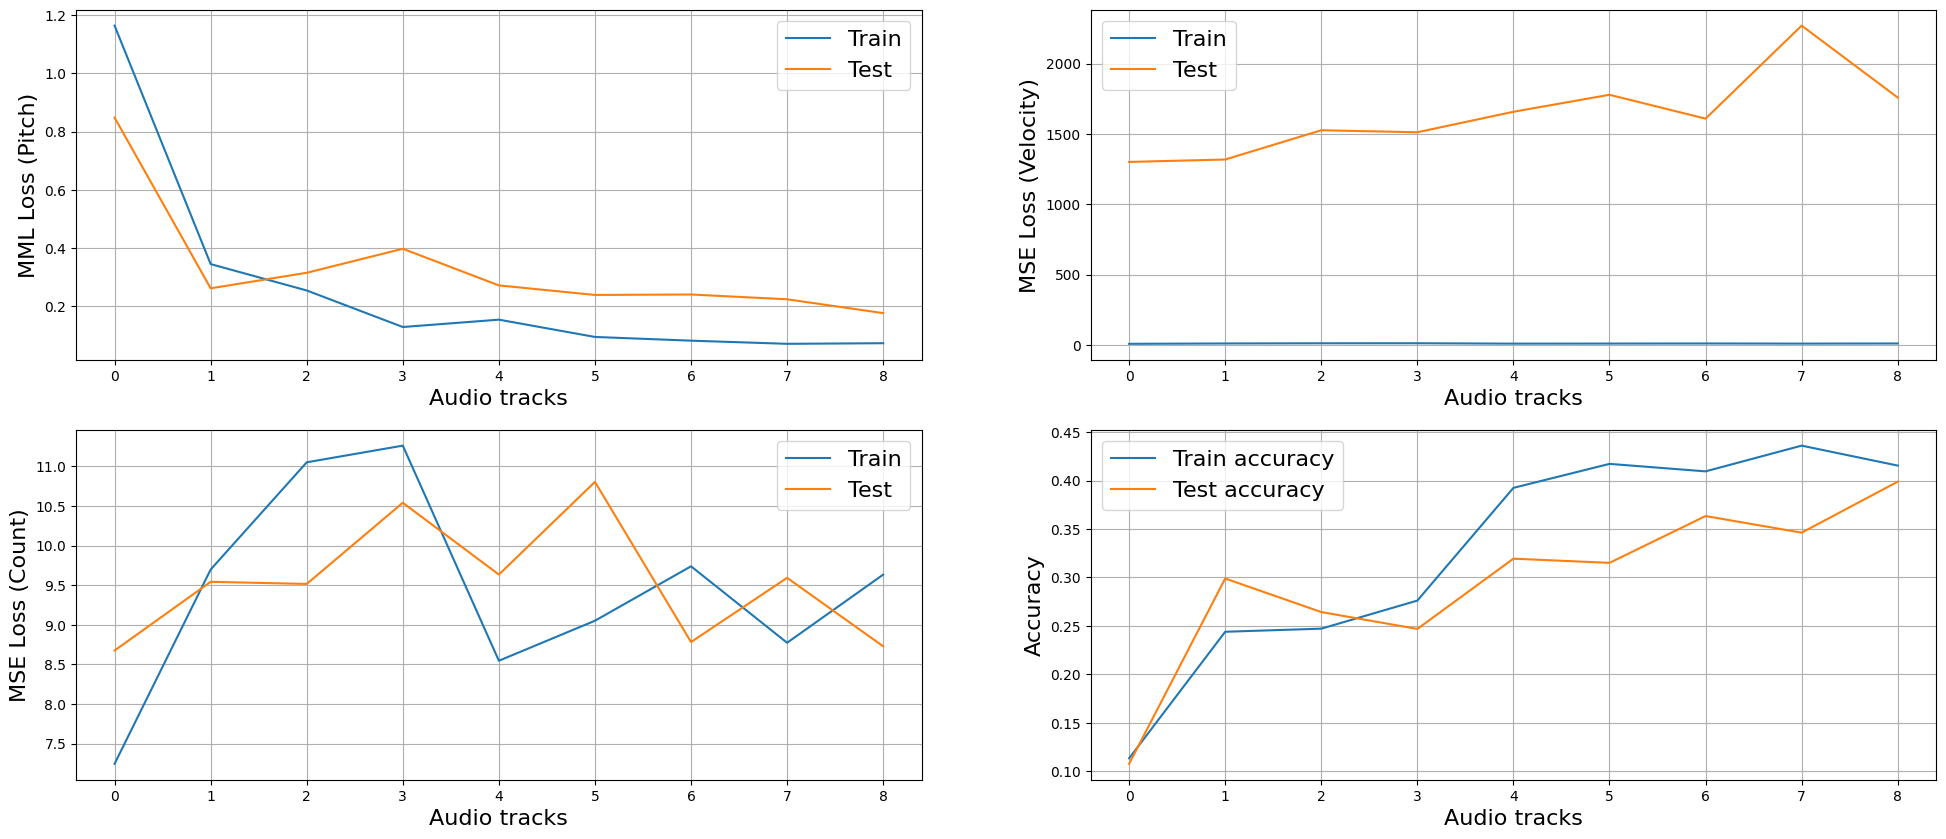

TRAIN: Epoch: 0000, Audio: 0009/0106, Pitch Loss: 0.0441, Vel Loss: 3306.8581, Count Loss: 19.6100:  12%|█▏        | 10/82 [00:02<00:20,  3.51it/s]


In [12]:
net = DummyNet().to(device)
# net.load_state_dict(torch.load("../models/model.ptx"))
train(net, 20, 1e-4, 100)

In [ ]:
torch.save(net.state_dict(), "../models/model.ptx")

In [ ]:
net = DummyNet().to(device)
net.load_state_dict(torch.load("../models/model.ptx"))

<All keys matched successfully>

In [ ]:
frames, notes, times = train_ds[12]
midi_filename, _ = train_ds._data.iloc[12]
ns = note_seq.midi_file_to_note_sequence(train_ds._root_path + midi_filename)

In [ ]:
len(notes)

12717

In [ ]:
def decode_predict(pitches, vels, pred_count):
    notes = []
    pitches = pitches.detach().cpu().numpy()
    vels = vels.detach().squeeze().cpu().numpy()
    pred_count = pred_count.detach().squeeze().cpu().numpy()
    for pitch, vel, count in zip(pitches, vels, pred_count):
        pred_size = (pitch >= pitch[128]).sum()
        pred_size = min(pred_size, 5)
        pitch = np.argsort(pitch)[::-1][:pred_size]
        vel = np.full_like(pitch, vel)

        notes.append((pitch, vel))
    return notes

In [ ]:
audio_ds = AudioDataset(frames, notes)
audio_loader = DataLoader(audio_ds, 100)

pred_notes = []

audio_iter = tqdm(audio_loader)
for X, pitch, vel, notes_count in audio_iter:
    X = X.to(device)
    pitch = pitch.to(device)
    vel = vel.to(device)
    notes_count = notes_count.to(device)

    pred_pitch, pred_vel, pred_count = net(X)
    pred_notes.extend(decode_predict(pred_pitch, pred_vel, pred_count))

100%|██████████| 128/128 [00:07<00:00, 16.24it/s]


In [ ]:
import bokeh

fig = note_seq.plot_sequence(ns, False)
fig_proc = note_seq.plot_sequence(detokenize(pred_notes, times, train_ds._frame_time), False)

fig.height = 500
fig_proc.height = 500
fig.width = 1500
fig_proc.width = 1500

bokeh.plotting.output_notebook()
bokeh.plotting.show(fig)
bokeh.plotting.show(fig_proc)

Loading BokehJS ...

In [ ]:
note_seq.play_sequence(ns)

In [ ]:
pred_ns = detokenize(pred_notes, times, train_ds._frame_time)
note_seq.play_sequence(pred_ns)